_**<h3 style="color: red"> If you intend on running this notebook, you might want to hit "run all" first so you don't have to wait to everything to render.</h3>**_

# How to visualize mobius transformations using Manim

## Background & Overview
[Mobius transformations](https://en.wikipedia.org/wiki/Möbius_transformation) are used in geometry and complex analysis. 
They are functions of the form:
$$f(z) = \frac{az+b}{bz+d},$$
where $a,b,c,d \in\mathbf C$ and $z$ is complex in general, as well.

If additionally, we require that $ab-cd=1$. 
That is, if we placed the coefficients into a matrix: 
$$\begin{bmatrix}a & b \\ c & d\end{bmatrix},$$
then the determinant is equal to one, then these are _unitary_ mobius transformations

Mobius transformations have applications in physics and mathematics, and they have a closely related cousin, called [quaternions](https://en.wikipedia.org/wiki/Quaternion), which are used in calculations involving three-dimensional rotations.

It can be proved that every transformation of this form does a composition of three things to the complex plane:
1. Translating/rotating the plane
2. Scaling the plane
3. Inverting the plane

In this project, I seek to replicate a well-known method of **visualizing these transformations** by using a model of the complex plane.
We will see that this class of transformations correspond exactly to rigid motions of a sphere in three dimension space, often called the [Riemann sphere](https://en.wikipedia.org/wiki/Riemann_sphere).

The tool I employ is [ManimCE](https://www.manim.community), the community-maintained version of ManimGL, which is what [3blue1brown](https://www.3blue1brown.com) uses to make his videos.


## Methodology & Code

To visualize these transformations, we rely on [stereographic projection](https://en.wikipedia.org/wiki/Stereographic_projection) to map the sphere to the plane.
We draw a line through a point on the sphere, and wherever it intersects the plane is where that point gets mapped to (it is okay if this is confusing, it will be visualized later).
This takes every point on the sphere to a point on the plane, so transforming the sphere will transform the plane.

We can also define an inverse mapping that maps every point on the plane to a point on the sphere.
Now, applying the **mobius transformations**, mentioned earlier, to the plane will produce an effect on the sphere.


First, install Manim and import it:


In [1]:
%%capture 
# if the install fails, uncomment the line above to read the error message
!pip install manim

In [2]:
import random
import math
from manim import *

config.media_width = "75%"
config.verbosity = "WARNING"
DEFAULT_DOT_RADIUS = 0.05

Manim Community v0.17.3

## UnitSphere Class, helper functions
Construct a class with useful methods to work with the UnitSphere. 
Also some functions to make coordinate conversions (not all of them are used).

In [3]:
class UnitSphere(Sphere):
    def __init__(self, radius=1, **kwargs):
        super().__init__(radius=radius, 
                         stroke_width=2,
                         fill_opacity=0.5,
                         **kwargs)
        self.axes = ThreeDAxes()
        self.set_fill_by_value(
            axes=self.axes, 
            colorscale=color_gradient([RED_E, RED, GREY, BLUE, BLUE_E], 5)
        )
        self.equator = self._construct_equator()
        self.add(self.equator)

    def _construct_equator(self):
        equator = Circle(radius=self.radius, stroke_width=7)
        equator.set_color_by_gradient(
            color_gradient([BLUE, GREEN], 10))\
            .set_z_index(self.z_index + 2)
        equator.move_to(self.get_center())
        return equator


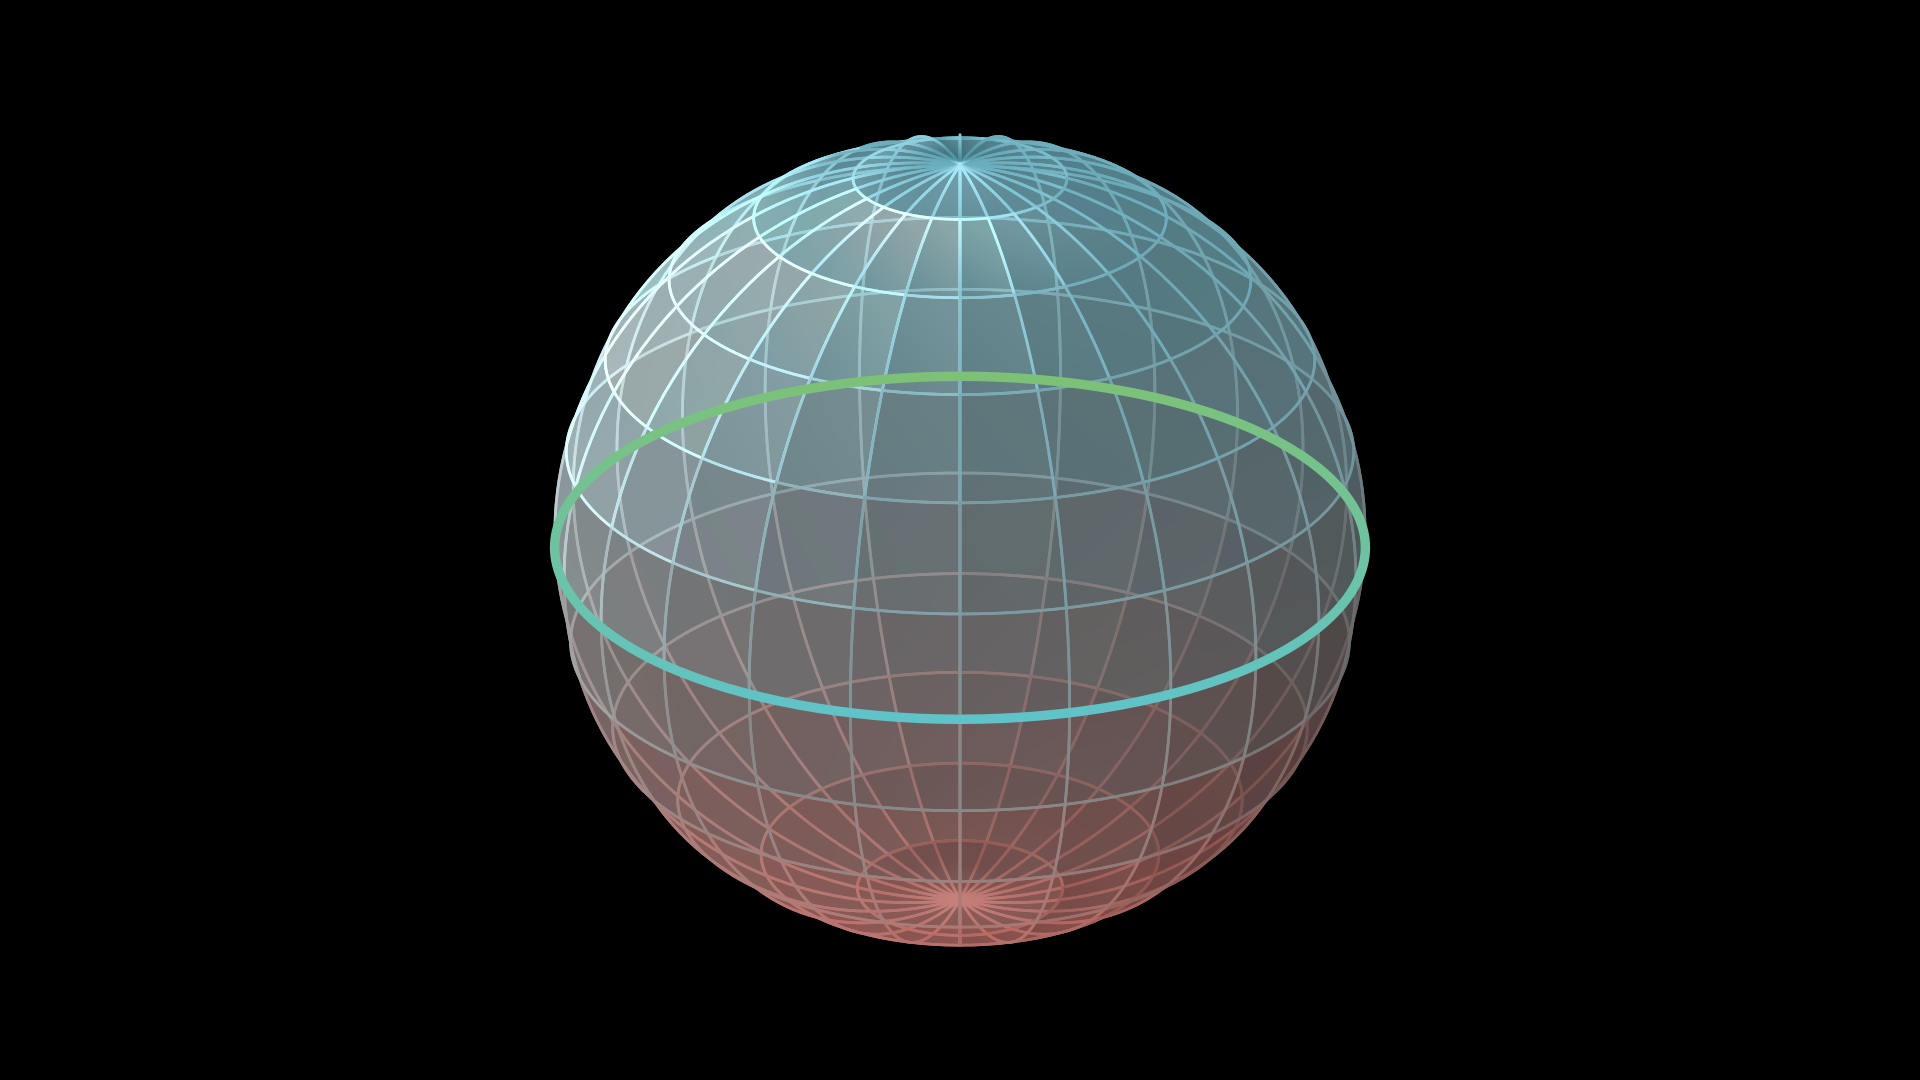

In [4]:
%%manim -qh SphereDemo

class SphereDemo(ThreeDScene):
  def construct(self):
    sphere = UnitSphere()
    self.set_camera_orientation(phi=65 * DEGREES, theta=-45 * DEGREES, zoom=3)
    self.add(sphere) # this adds it to the scene to be rendered


In [5]:
def stereographic_projection (source: np.ndarray, point: np.ndarray) -> np.ndarray:
    """
    Given a source point on the sphere and the point that is to be projected,
    returns the stereographic projection of the point onto the plane.

    Parameters
    ----------
    source : np.ndarray
        The source point on the sphere. Usually the north pole.
    point : np.ndarray
        The point to be projected onto the plane.
    
    Returns
    -------
    np.ndarray
        3D-coordinates of the projected point. z is always 0.
    """
    Nx, Ny, Nz = source
    shift = np.asarray([Nx, Ny, 0])
    x, y, z = point - shift

    # an ultimately futile attempt to fix a graphics glitch, see section Equator projector
    if math.isclose(Nz, abs(z)):
        if x > Nx:
            return np.asarray([10, 0, 0])
        elif x < Nx:
            return np.asarray([-10, 0, 0])
        elif y > Ny:
            return np.asarray([0, 10, 0])
        elif y < Ny:
            return np.asarray([0, -10, 0])
        else:
            return None


    r = np.sqrt(x**2 + y**2)
    r_p = Nz * r / (Nz - z)
    theta_p = np.arctan2(y, x)
    proj_coords = polar_to_cartesian(r_p, theta_p) + shift
    # if any(abs(proj_coords) > 100):
    #     return np.asarray([0, 0, 0]) + shift
    return proj_coords
def cartesian_to_polar(coords: np.ndarray):
    x, y = coords
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return np.asarray([r, theta])

def polar_to_cartesian(r, theta):
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return np.asarray([x, y, 0])

## Point projector
Next we define the PointProjector, which is a Manim object containing a plane, a sphere, and methods to construct projections. 
Most of the work was spent on this class.

In [31]:
class PointProjector(VGroup):
    def __init__ (self, sphere: Sphere, **kwargs):
        super().__init__()
        self.sphere = sphere
        self.plane = ComplexPlane(
            background_line_style={
                "stroke_color": GREY_A,
                "stroke_width": 1,
                "stroke_opacity": 0.5,
            },
            **kwargs,
        )
        self.sphere.move_to(self.plane.coords_to_point(0, 0))

        # the following two things are defined so that various objects can be manipulated as a whole 
        self.base = self.sphere + self.plane
        self.s_ext = self.sphere + self.sphere.equator
        self.projection_mobs = VGroup()

        self.add(
            self.base,
            self.s_ext)
    
    def begin_projection (
            self,
            point: tuple[float, float],
            draw_lines=True):
        """
        Creates the projection line, the projected point, and its destination.
        Also initializes updaters so that they are updated every frame.

        Parameters
        ----------
        point : tuple[float, float]
            The point to be projected onto the sphere. Given in (u, v) coordinates.
            u should range [0, 2pi] and is the phi angle on the sphere.
            v should range [0, pi] and is the (negative) theta angle on the sphere.
        draw_lines : bool, optional
            Whether or not to draw lines from the horizontal axes to the projected point.
        """
        self.P = Dot3D(color=RED, radius=0.05).set_z_index(self.z_index + 1)
        self.L = self.line_from_top(self.sphere.func(point[0], point[1]))
        self.P_proj = Dot3D(color=YELLOW, radius=0.05).set_z_index(self.z_index + 2)

        self.create_point_labels()
        self._new_stereographic_projection(point, draw_lines=draw_lines)

        self.s_ext.add(self.P, self.L)
        self.add(self.P_proj, self.proj_lines)
        self.projection_mobs = self.P_proj + self.L + self.P_proj + self.proj_lines
        return self.P, self.L, self.P_proj
    
    def end_projection (self):
        """
        Stop the updaters that keep the projection line and point up to date.
        """
        self.projection_mobs.clear_updaters()

    def create_point_labels (self) -> tuple[Matrix, Matrix]:
        """
        Create coordinate labels for the point and its projection. 
        """
        P_label = Matrix([np.round(self.P.get_center(), 2)]).scale(0.3)
        P_proj_label = Matrix([np.round(self.P_proj.get_center(), 2)]).scale(0.3)

        self.labels = (P_label, P_proj_label)
        self.add(*self.labels)
        self.projection_mobs.add(*self.labels)
        return self.labels

    def get_point_labels (self) -> tuple[Matrix, Matrix]:
        """
        Updates the point labels to the current coordinates of the points.
        """
        self.labels[0].become(Matrix([np.round(self.P.get_center(), 2)]).scale(0.3))
        self.labels[1].become(Matrix([np.round(self.P_proj.get_center(), 2)]).scale(0.3))
        return self.labels

    def new_projected_point (self, point: tuple[float, float], draw_lines=True):
        """
        Set a new point to be projected. Returns animations that move the point and
        the projection line to the line that connects the north pole and the new point.
        """
        coords = self.sphere.func(point[0], point[1])
        new_L = self.line_from_top(coords)
        
        return self.P.animate.move_to(coords), Transform(self.L, new_L)

    def _new_stereographic_projection (self, point: tuple[float, float], draw_lines=True):
        """
        Moves the target point to the given coordinates on the sphere, and
        add updaters for the projection point so it always moves to the 
        stereographic projection of the target point.
        """
        s = self.sphere
        def move_with_P (P_proj):
            P_proj.move_to(stereographic_projection(
                s.get_zenith(), 
                self.P.get_center()))

        self.P.move_to(s.func(point[0], point[1]))
        move_with_P(self.P_proj)
        self.P_proj = self.P_proj.add_updater(move_with_P)
    
        if draw_lines:
            def lines_to_proj ():
                return self.plane.get_lines_to_point(self.P_proj.get_center(), 
                                                     color=YELLOW_A,
                                                     stroke_width=2,
                                                     line_func=Line)
            self.proj_lines = always_redraw(lines_to_proj)
    
    def line_from_top (self, point: np.ndarray, length=8):
        """
        Returns a line from the top of the sphere through the given point.
        """
        top = self.sphere.get_zenith()
        line_dir = (point - top)
        line = Line3D(start=top, end=top + line_dir * length, color=BLUE)
        return line
    
    def strip_to_equator (self):
        """
        Returns animations that removes the sphere's outlines and color fill, as 
        well as projection mobjects, and creating the equator
        """
        stripped = self.sphere.copy().set_stroke(opacity=0).set_fill(BLUE_B)
        return Transform(self.sphere, stripped),\
                        FadeOut(self.projection_mobs, shift=OUT),\
                        Create(self.sphere.equator, lag_ratio=0.1)

    def rotate_sphere (self, angle, axis=OUT, **kwargs):
        """
        Returns animations that rotate the sphere and mobjects on it about the z-axis.
        """
        return self.s_ext.animate.rotate(
            angle,
            axis=axis,
            about_point=self.sphere.get_center(),
            **kwargs)


### **Demoing the point projector**

[04/25/23 00:12:50] WARNING  Attempted adding some Mobject as a child more than once, this is not    ]8;id=768435;file:///Users/kenneth/opt/anaconda3/lib/python3.9/site-packages/manim/mobject/mobject.py\mobject.py]8;;\:]8;id=594313;file:///Users/kenneth/opt/anaconda3/lib/python3.9/site-packages/manim/mobject/mobject.py#436\436]8;;\
                             possible. Repetitions are ignored.                                                    

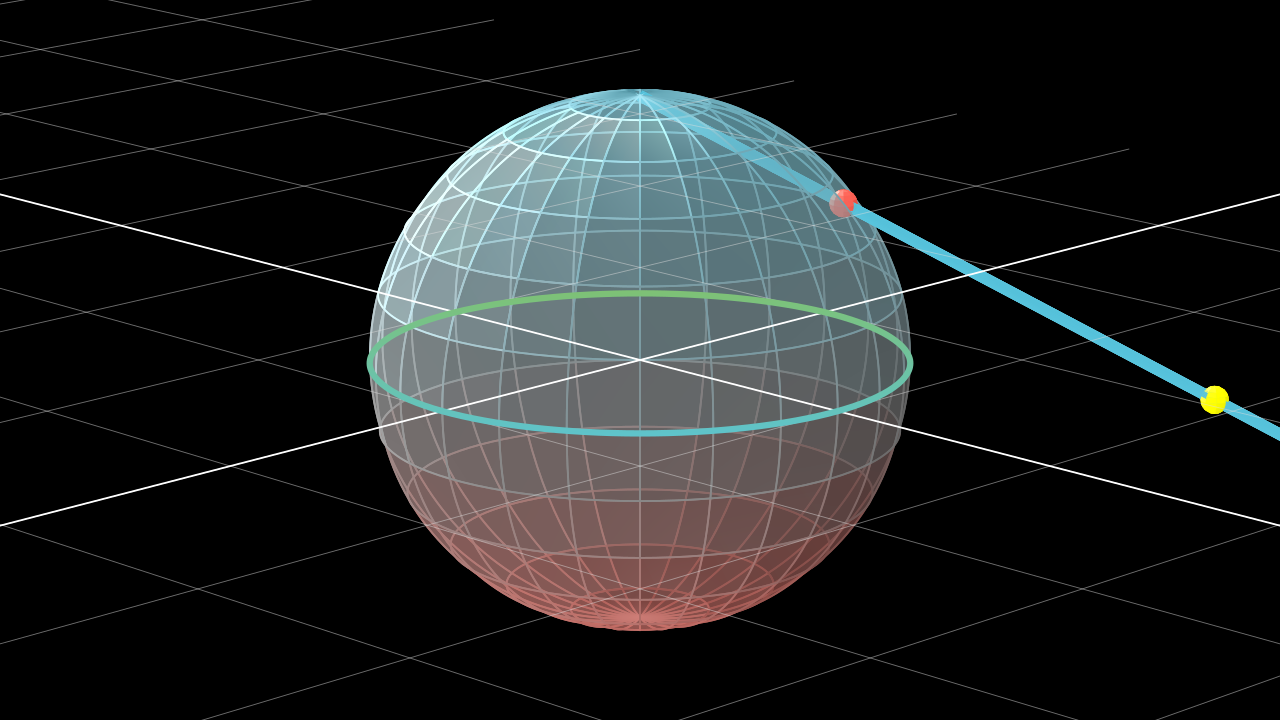

In [32]:
%%manim -ql ProjectionDemo

class ProjectionDemo(ThreeDScene):
    def construct (self):
        sphere = UnitSphere()
        point_p = PointProjector(sphere)
        self.set_camera_orientation(phi=75 * DEGREES, theta=-45 * DEGREES, zoom=3)
        # only add the base, otherwise objects will appear before we want them to
        self.add(point_p.base) 
        self.play(Succession(
            *[Create(m) for m in point_p.begin_projection(
            (30*DEGREES, 130*DEGREES),
            draw_lines=True)],
            run_time=3))
        self.wait()


### **More demoing with changing points**

In [8]:
%%manim -ql MoreProjectionDemo

class MoreProjectionDemo(ThreeDScene):
    def construct (self):
        sphere = UnitSphere()
        # self.point_p = PointProjector(sphere, x_range=[-6, -6, 1], y_range=[-4, 4, 1])
        self.point_p = PointProjector(sphere)
        self.set_camera_orientation(phi=75 * DEGREES, theta=-45 * DEGREES, zoom=3)
        # only add the base, otherwise objects will appear before we want them to
        self.add(self.point_p.base) 
        self.demo_point_projection()
        self.wait(2)

    def demo_point_projection(self):
        points = [
            (30*DEGREES, 130 * DEGREES),
            (2*PI/3, 30 * DEGREES),
            (2.3*PI/2, 50 * DEGREES),
            (135 * DEGREES, 70 * DEGREES),
        ]
        self.start_point_stereographic_projection(points[0])
        self.move_camera(theta=PI/4)

        for p in points[1:]:
            self.play(*self.point_p.new_projected_point(p), run_time=1)
            self.wait(0.5)

        self.move_sphere_around(self.point_p.s_ext)

    def start_point_stereographic_projection(
            self, 
            point: tuple[float, float],
            draw_lines=True):

        self.play(Succession(
            *[Create(m) for m in self.point_p.begin_projection(
            (30*DEGREES, 130*DEGREES),
            draw_lines=True)],
            run_time=1))
        
        if draw_lines:
            self.play(Create(self.point_p.proj_lines), run_time=0.5)

    def move_sphere_around (self, s):
        self.play(s.animate.shift(LEFT))
        self.play(
            self.point_p.rotate_sphere(-30 * DEGREES, axis=OUT),
            run_time=1)
        self.play(s.animate.shift(OUT))
        self.play(self.point_p.rotate_sphere(20*DEGREES, axis=LEFT),
                  rate_func=there_and_back_with_pause,
                  run_time=1.5)


[04/24/23 23:41:07] WARNING  Attempted adding some Mobject as a child more than once, this is not    ]8;id=284644;file:///Users/kenneth/opt/anaconda3/lib/python3.9/site-packages/manim/mobject/mobject.py\mobject.py]8;;\:]8;id=105532;file:///Users/kenneth/opt/anaconda3/lib/python3.9/site-packages/manim/mobject/mobject.py#436\436]8;;\
                             possible. Repetitions are ignored.                                                    

## Equator projector
Now that there is a robust way to project points on the sphere, we can extend this to the equator.
Considering where the equator of the sphere gets mapped to gives us a good idea to understand what any transformation does to the entire sphere.


In [9]:
class EquatorProjector(PointProjector):
    def __init__ (self, sphere: Sphere, **kwargs):
        super().__init__(sphere, **kwargs)
        self.equator = sphere.equator
    
    def begin_projection (self):
        def eq_proj ():
            return self.equator.copy().set_stroke(color=YELLOW).apply_function(
                lambda p: stereographic_projection(self.sphere.get_zenith(), p))
            
        # calls eq_proj every frame and updates the equator to the new one
        self.eq_proj = always_redraw(eq_proj)
        self.add(self.eq_proj)
        return self.eq_proj

[04/25/23 00:32:53] WARNING  Attempted adding some Mobject as a child more than once, this is not    ]8;id=350572;file:///Users/kenneth/opt/anaconda3/lib/python3.9/site-packages/manim/mobject/mobject.py\mobject.py]8;;\:]8;id=168920;file:///Users/kenneth/opt/anaconda3/lib/python3.9/site-packages/manim/mobject/mobject.py#436\436]8;;\
                             possible. Repetitions are ignored.                                                    

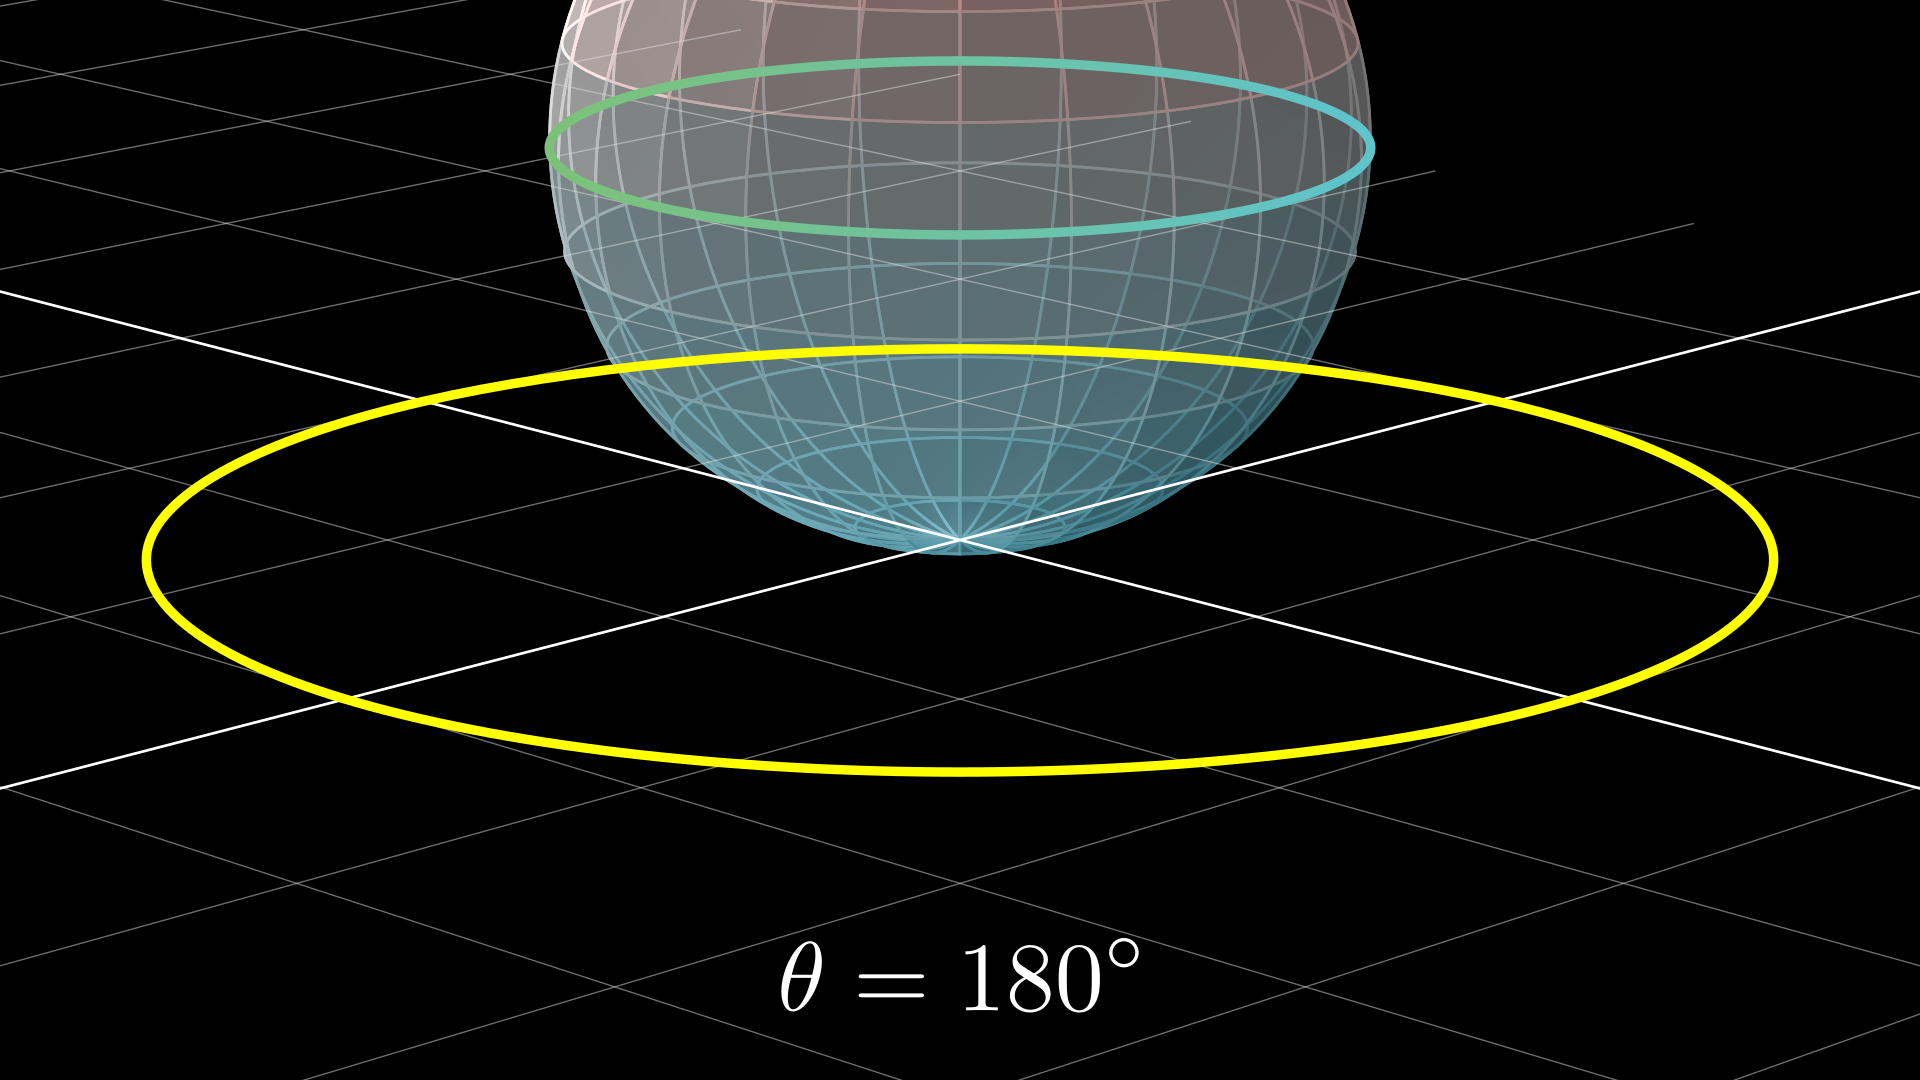

In [71]:
%%manim -ql EquatorDemo

class EquatorDemo(ThreeDScene):
    def construct (self):
        sphere = UnitSphere().move_to(ORIGIN).set_z_index(2)
        ep = EquatorProjector(sphere)
        # theta = 180 * DEGREES
        # angle = MathTex(r"\theta = ", f"{theta/DEGREES:.0f}^\\circ", font_size=70).to_edge(DOWN)
        self.add_fixed_in_frame_mobjects(angle)
        self.set_camera_orientation(phi=75 * DEGREES, theta=-45 * DEGREES, zoom=3)

        self.add(ep) 
        # ep.s_ext.shift(OUT).rotate(theta, axis=LEFT)
        ep.begin_projection()
        self.play(ep.s_ext.animate.shift(OUT))
        self.play(Rotate(ep.s_ext, PI/2, axis=LEFT))
        self.wait(0.2)
        self.play(Rotate(ep.s_ext, PI/2, axis=LEFT))

        self.play(Rotate(ep.s_ext, PI/2, axis=UP))
        self.wait(0.2)
        self.play(Rotate(ep.s_ext, PI/2, axis=UP))
        self.wait()



## Results

There is a visual glitch while transforming the line which I'm not too sure how to get rid of, but this transformation illustrates an important point.

In stereographic projection, what happens if you try to project the source point? 
It cannot be zero, because the opposite point is already mapped to zero:


[04/24/23 23:42:55] WARNING  Attempted adding some Mobject as a child more than once, this is not    ]8;id=987083;file:///Users/kenneth/opt/anaconda3/lib/python3.9/site-packages/manim/mobject/mobject.py\mobject.py]8;;\:]8;id=823837;file:///Users/kenneth/opt/anaconda3/lib/python3.9/site-packages/manim/mobject/mobject.py#436\436]8;;\
                             possible. Repetitions are ignored.                                                    

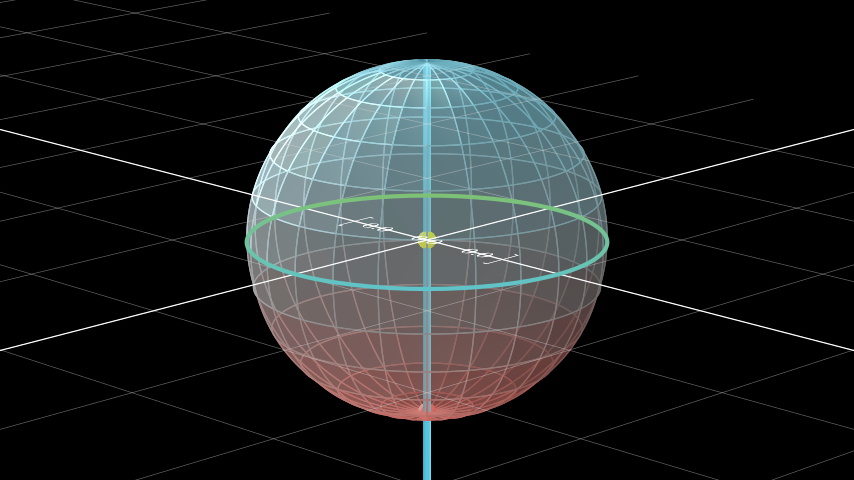

In [11]:
%%manim -ql OppositePoint

class OppositePoint(ThreeDScene):
    def construct (self):
        pp = PointProjector(UnitSphere())
        self.set_camera_orientation(phi=75 * DEGREES, theta=-45 * DEGREES, zoom=3)
        pp.begin_projection((0, 0))
        self.add(pp)

In the calculation, this translates to an attempt to divide by zero, which we then define to be infinity. 
The equator animation then says: when you turn the sphere 90 degrees and project the equator, it gets mapped into a line extending to infinity. 
This makes sense because, no matter where you started on the equator, if you keep walking in one direction you'll eventually end up at the same spot then if you had started in the other direction.

I could not show it here, but it turns out that this generalizes to the sphere and its projection into the plane: one point gets mapped to infinity, so that no matter which direction you go in, you eventually end up at that point.
It's analogous to how if you started walking from the south pole in a straight line, you'll eventually end up at the north pole.


## Discussion
There is a lot more that could be done with this project, and with Manim in general.
It was unexpectedly difficult to learn and use Manim, so most of the time spent on this project ended up going towards debugging rather than making progress towards visualizing arbitrary mobius transformations (which was what I originally intended to do).

The project ended up taking a large detour, too, as I divulged focus towards creating expositionary animations that would guide a general audience towards understanding of the topic, rather than directly applying a transformation to the plane and showing it on the sphere, or vice versa. 

One significant mistake I made during development was worrying too much about transitions between scenes.
They caused 80% of the headache, but are almost entirely decorative (the pitfalls of trying to imitate 3b1b).
But I'm stubborn, so I wanted it to look and work exactly the way I'd envisioned.
It probably would've been easier to write the pieces individually, like I've done in this notebook, and worry about transitions after the fact.

Another big learning experience is to not start too overly-ambitious. 
I lept to ThreeDScenes without first being familiar with regular, two dimensional scenes. 
It turns out they are much less supported and have way more room for error.

In any case, the things I didn't get to should be decently easy to implement now that the structure is set up.
In particular, they are:

1. Show the sphere and where its equator is projected to, on a seperate 2-D plane, then do stuff to the sphere to see what happens to the equator. 
It is probably more desirable to apply the method on the entire complex plane, but I don't know how this will look.
2. The reverse direction is more complicated.
To show the effects of a mobius transformation on the sphere, it is not enough to just show the equator. 
Possible alternatives include: four noncoplanar points (not all on the same plane) uniquely determine a sphere, so we can keep track of where four such points map to, we could do that and just reconstruct the sphere at those points.
We could also just calculate the expected rotation and apply it to the sphere directly. This saves computing power. Manim actually almost has a function for this because of 3b1b's video on quaternions, which are closely related.
3. Adding coordinate labels to points. I actually wrote the functions for this but decided not to deal with potential friction in implementation.
4. Using complex representations of points. 
Since I never got to showing the inverse relation (mobius transformations on the plane -> motions of the sphere), it was thus far not necessary to use complex numbers. 
But mobius transformations are complex in general and uses properties of complex arithmetic, so that would be a necessary step to move forward.

---

I hope that this project has established some belief in the relation between the Riemann sphere and the complex plane.
Even though the reverse direction was not presented, there are still things to observe about the foward direction:

1. Stereographic projection is a conformal mapping, meaning angle measure is preserved. 
In the equator projection animation, we saw that a circle on the sphere maps to a circle in the plane. 
In fact, the straight line obtained when the sphere's equator is completely "vertical" is _also_ a circle, technically. 
A generalized circle in $\mathbb C$ together with $\infty$ is either a straight line or a circle.
2. The projection, with the original sphere centered at the origin, sends the equator to the unit circle, the upper hemisphere to the disk bound by the unit circle, and the lower hemisphere to the rest of the plane.



## References
Unfortunately, there are not many great tutorials. 
These are some of the resources I scrapped together, but mostly this project was trial-and-error, and digging into Manim's source code.
These are gathered from my browser's history.

Manim docs (used extensively): https://docs.manim.community/en/stable/

Youtube videos: 
- https://www.youtube.com/watch?v=KeXBLPC1tns
- https://www.youtube.com/watch?v=j449Isga0Es&t=10s
- https://www.youtube.com/watch?v=FEtYAw3sI9Y


Various SO posts:
- https://stackoverflow.com/questions/67233729/in-manim-how-to-change-axis-number-font-color
- https://stackoverflow.com/questions/72926411/transform-function-animate-in-manim
- https://stackoverflow.com/questions/59787599/how-to-apply-transform-on-cartesian-plane-numberplane-to-polar-plane
- https://stackoverflow.com/questions/65667974/in-manim-how-do-you-move-the-left-edge-of-an-object-to-a-particular-vector
- https://stackoverflow.com/questions/68378177/how-to-move-the-camera-in-3d-space-while-animation-is-done-in-manim

Various reddit posts: 
- https://www.reddit.com/r/manim/comments/lmpxjd/how_to_create_a_numberplane_which_fades_out_at/
- https://www.reddit.com/r/manim/comments/mpaf6d/selfremoveobject_doesnt_seem_to_work/
- https://www.reddit.com/r/manim/comments/t9en5c/move_and_animate_at_the_same_time/
- https://www.reddit.com/r/manim/comments/w3ucmp/how_to_draw_a_rectangle_around_a_portion_of_a/

Occassionaly Github issues: https://github.com/ManimCommunity/manim/issues/2762